Football (or soccer to my American readers) is full of clichés: "It's a game of two halves", "taking it one game at a time" and "Liverpool have failed to win the Premier League". You're less likely to hear "Treating the number of goals scored by each team as independent Poisson processes, statistical modelling suggests that the home team have a 60% chance of winning today"

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam
from IPython.core.pylabtools import figsize
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Dataset and motivation slide

We'll import all match results from the recently concluded Premier League (2016/17) season. The model is founded on the number of goals scored/conceded by each team. Teams that have been higher scorers in the past have a greater likelihood of scoring goals in the future.

In [3]:
!wget http://www.football-data.co.uk/mmz4281/1617/E0.csv

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/chuanjie/.wget-hsts'. HSTS will be disabled.
--2019-06-03 14:28:51--  http://www.football-data.co.uk/mmz4281/1617/E0.csv
Resolving www.football-data.co.uk (www.football-data.co.uk)... 217.160.0.246
Connecting to www.football-data.co.uk (www.football-data.co.uk)|217.160.0.246|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99990 (98K) [text/csv]
Saving to: ‘E0.csv.1’

E0.csv.1            100%[===================>]  97.65K   212KB/s    in 0.5s    

2019-06-03 14:28:51 (212 KB/s) - ‘E0.csv.1’ saved [99990/99990]



In [4]:
results = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
results = results[['HomeTeam','AwayTeam','FTHG','FTAG']]
results = results.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
results.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1


## Research Question

We imported a csv as a pandas dataframe, which contains various information for each of the 380 EPL games in the 2016-17 English Premier League season. We restricted the dataframe to the columns in which we're interested (specifically, team names and number of goals scored by each team).

Our task is to model the match results between the two teams.

In [5]:
results = results[:-10]
results.mean()



HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

on average, the home team scores more goals than the away team. This is the so called 'home (field) advantage' 

## The Poisson distribution. 
It's a discrete probability distribution that describes the probability of the number of events within a specific time period (e.g 90 mins) with a known average rate of occurrence. 

![jupyter](./math.svg)

$\lambda$ represents the average rate (e.g. average number of goals). So, we can treat the number of goals scored by the home and away team as two independent Poisson distributions. The plot below shows the proportion of goals scored compared to the number of goals estimated by the corresponding Poisson distributions.

In [10]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(8)] for j in range(2)])
poisson_pred

array([[2.03540171e-01, 3.06118259e-01],
       [3.24013948e-01, 3.62377831e-01],
       [2.57897589e-01, 2.14488500e-01],
       [1.36848360e-01, 8.46360027e-02],
       [5.44619487e-02, 2.50476819e-02],
       [1.73395069e-02, 5.93020793e-03],
       [4.60043674e-03, 1.17001400e-03],
       [1.04619971e-03, 1.97863371e-04]])

/home/chuanjie/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


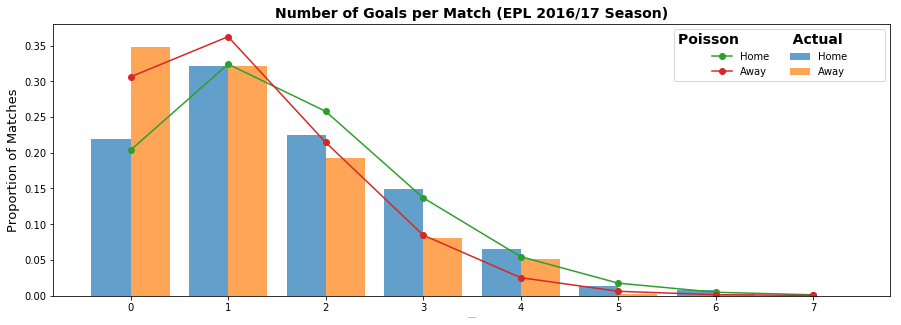

In [61]:
# construct Poisson  for each mean goals value, plot histogram of actual goals and add lines for the Poisson distributions
figsize(15, 5)
plt.hist(results[['HomeGoals', 'AwayGoals']].values, range(9), alpha=0.7, label=['Home', 'Away'],normed=True)
pois1 = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],linestyle='-', marker='o',label = 'Home')
pois2 = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],linestyle='-', marker='o',label="Away")
leg=plt.legend(loc='upper right', fontsize=10,ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=1)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')

plt.show()

Note that we consider the number of goals scored by each team to be independent events (i.e. P(A n B) = P(A) P(B)). The difference of two Poisson distribution is actually called a Skellam distribution. So we can calculate the probability of a draw by inputting the mean goal values into this distribution.

In [64]:
# probability of draw between home and away team
skellam.pmf(0.0,  results.mean()[0],  results.mean()[1])

0.24809376810717076

In [65]:
# probability of home team winning by one goal
skellam.pmf(1,  results.mean()[0],  results.mean()[1])

0.22706765807563964

/home/chuanjie/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


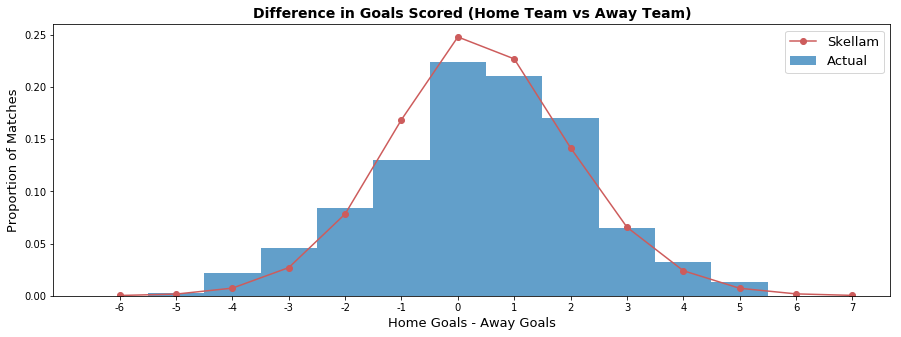

In [66]:
figsize(15, 5)
skellam_pred = [skellam.pmf(i,  results.mean()[0],  results.mean()[1]) for i in range(-6,8)]
plt.hist(results[['HomeGoals']].values -results[['AwayGoals']].values, range(-6,8), alpha=0.7, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.show()